# Yield Curve Forecasting Using Machine Learning

## Problem Statement
The yield curve summarizes market expectations about economic growth,
inflation, and monetary policy. Accurate forecasting of long-term yields,
particularly the 10-year Treasury yield, is critical for fixed-income
valuation, risk management, and macroeconomic analysis.

This project develops a machine learning pipeline to model and predict
yield curve dynamics using historical Treasury yields and engineered
macroeconomic features.


In [13]:
# IMPORTS AND CONFIGURATIONS

# Core data libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [14]:
# DATA LOADING AND VALIDATION

# Load processed yield curve dataset
df = pd.read_csv("Processed_data.csv")

# Basic validation checks
assert not df.empty, "Dataset is empty"
assert '10Y' in df.columns, "Target yield not found"

df.head()


,Unnamed: 0,1M,3M,1Y,2Y,5Y,10Y,30Y
0,2001-07-31,3.67,3.54,3.53,3.79,4.57,5.07,5.51
1,2001-08-01,3.65,3.53,3.56,3.83,4.62,5.11,5.53
2,2001-08-02,3.65,3.53,3.57,3.89,4.69,5.17,5.57
3,2001-08-03,3.63,3.52,3.57,3.91,4.72,5.20,5.59
4,2001-08-06,3.62,3.52,3.56,3.88,4.71,5.19,5.59


In [15]:
# DATA HANDLING

# Convert date column into time-series index
df['Date'] = pd.to_datetime(df['Unnamed: 0'])
df = df.drop(columns=['Unnamed: 0'])
df.set_index('Date', inplace=True)

# Ensure chronological order
df = df.sort_index()



In [16]:
# FEATURE ENGINEERING

# Yield spreads capture curve shape and recession signals
df['spread_10y_2y'] = df['10Y'] - df['2Y']
df['spread_5y_3m'] = df['5Y'] - df['3M']
df['spread_30y_10y'] = df['30Y'] - df['10Y']

# Rolling statistics capture trend and volatility regimes
df['vol_30d'] = df['10Y'].rolling(30).std()
df['vol_90d'] = df['10Y'].rolling(90).std()
df['ma_30'] = df['10Y'].rolling(30).mean()
df['ma_90'] = df['10Y'].rolling(90).mean()


for lag in [1, 5, 10]:
    df[f'10Y_lag_{lag}'] = df['10Y'].shift(lag)


In [17]:
# TARGET CONSTRUCTION

# Predict next-period 10Y yield (forward-looking)
df['target_10Y'] = df['10Y'].shift(-1)
df = df.dropna()


In [18]:
# TRAIN - TEST SPLIT

X = df.drop(columns=['target_10Y', '10Y'])
y = df['target_10Y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)



In [19]:
# MODELING

# 1) LINEAR REGRESSION (BASELINE)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)


In [20]:
# RANDOM FOREST REGRESSOR (NON-LINEAR)

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [23]:
# EVALUATION

def evaluate(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

print(evaluate(y_test, y_pred_lr))
print(evaluate(y_test, y_pred_rf))


{'RMSE': np.float64(0.06269470467229049), 'MAE': 0.048893517887186294, 'R2': 0.9967096054244957}
{'RMSE': np.float64(0.09648895657265229), 'MAE': 0.07567841345740375, 'R2': 0.9922063395886155}


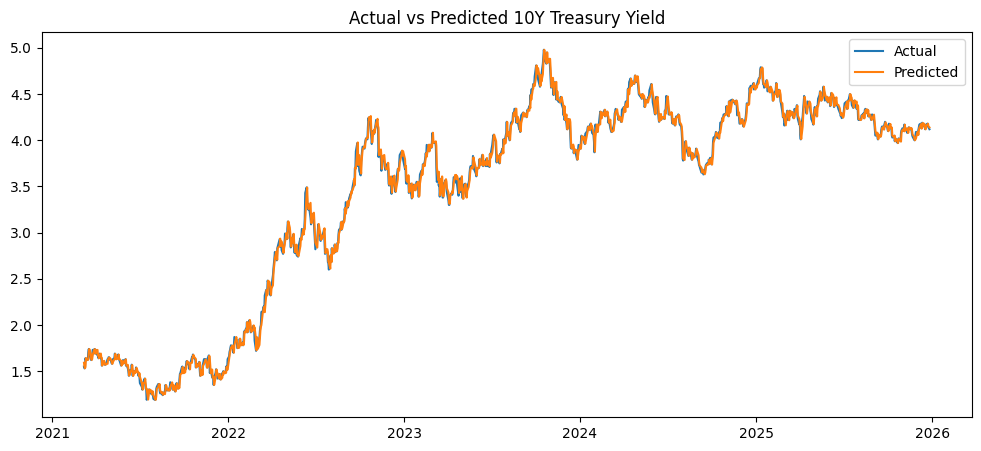

In [25]:
# INTERPRETATION AND VISUALISATION (LINEAR REGRESSION)

plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_lr, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted 10Y Treasury Yield")
plt.show()


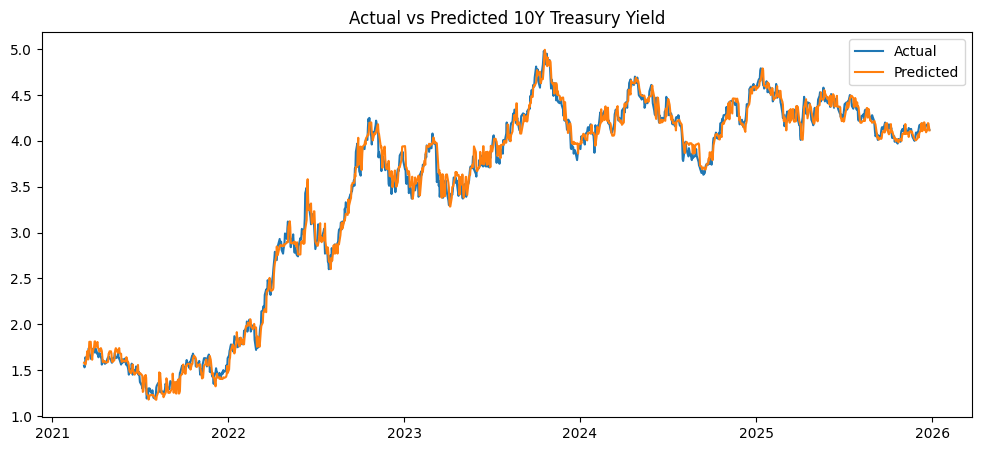

In [ ]:
# INTERPRETATION AND VISUALISATION (RANDOM FOREST)

plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_rf, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted 10Y Treasury Yield")
plt.show()


## Key Takeaways
- Yield curve slope and long-end rates dominate predictive power
- Tree-based models outperform linear baselines
- Feature engineering grounded in finance theory is critical
